### Import Modules and Pathways

In [1]:
# Set pathways and initialize model
import os
import re
import time
import torch

import numpy as np
import pandas as pd
import utils.preprocess as preprocess
import utils.evaluate as evaluate

from collections import defaultdict
from cellpose import models, core, io

# set pathways to test files
# Paths to annotated test data
base_dir = '/home/elyse/Documents/GitHub/LS_evaluation_tool/test_data/images/'
output_root = '/home/elyse/Documents/GitHub/LS_evaluation_tool/test_data/cellpose_output'

# create output directory if it doesn't already exist
if not os.path.exists(output_root):
    os.mkdir(output_root)

# have cellpose log run
io.logger_setup()

# initialize model
use_GPU = core.use_gpu()
model = models.Cellpose(gpu = use_GPU, model_type = 'nuclei')


In /home/elyse/miniconda3/envs/segment_compare/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elyse/miniconda3/envs/segment_compare/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elyse/miniconda3/envs/segment_compare/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/elyse/miniconda3/envs/segment_compare/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed tw

2022-12-07 12:28:52,797 [INFO] WRITING LOG OUTPUT TO /home/elyse/.cellpose/run.log
2022-12-07 12:28:55,668 [INFO] ** TORCH CUDA version installed and working. **
2022-12-07 12:28:55,670 [INFO] ** TORCH CUDA version installed and working. **
2022-12-07 12:28:55,670 [INFO] >>>> using GPU
2022-12-07 12:28:55,671 [INFO] >> nuclei << model set to be used
2022-12-07 12:28:55,869 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)


### Import Annotation Data

In [2]:
# Get annotated data and image file paths
blocks = defaultdict(dict)

# loop through base directory and collect all data from "block_#" subfolders
for root, dirs, files in os.walk(base_dir):
    if 'block' in root: 
        for file in files:
            try:
                block_num = re.findall('[0-9]', file)[0]
            except:
                continue
            if 'signal' in file:
                blocks[block_num]['signal'] = os.path.join(root, file)
            elif 'background' in file:
                blocks[block_num]['background'] = os.path.join(root, file)
            elif 'detect' in file:
                blocks[block_num]['detect'] = preprocess.get_locations(os.path.join(root, file))
            else:
                blocks[block_num]['reject'] = preprocess.get_locations(os.path.join(root, file))

# print info on blocks        
for key in blocks.keys():
    try:
        rejected = len(blocks[key]['reject'])
    except:
        rejected = 0
    print('Pulled annotation data for block {0}: {1} cells and {2} noncells.'.format(str(key), len(blocks[key]['detect']), rejected))

Pulled annotation data for block 4: 2168 cells and 0 noncells.
Pulled annotation data for block 1: 1751 cells and 2 noncells.
Pulled annotation data for block 3: 410 cells and 5 noncells.
Pulled annotation data for block 2: 1641 cells and 2 noncells.


### Initialize Pretrained Cellpose

In [3]:
# There are 3 ways to run 3D Cellpose. The first 2 are exrapolating 2D to 3D
# This is very time consuming if ytou do not GPU access
# The Third way is using new Cellpose3D repo in other script
import skimage.io
import utils.preprocess as pp
from skimage.measure import regionprops

# Set parameters
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# flow_threshold not used for 3D (see git code) so dont need to mess with
channels = [0,0]
prob_thresh = 0
stitch_thresh = 0.5
diameter = 9 # unit = px
min_size = 36
detect_times = defaultdict(int)

# which methods and channels do you want to run for cellpose
methods = ['flow']
chs = ['signal', 'background']

# parameters for preprocessing
bkg_sub = True
estimator = 'SExtractorBackground'
pad = 50

for method in methods:
    start_detect = time.time()
    for key in blocks.keys():
        for ch in chs:
            fname = os.path.basename(blocks[key][ch])[:-4]
            img = skimage.io.imread(blocks[key][ch])
            
            if bkg_sub:
                img = pp.astro_preprocess(img, estimator, pad = pad)
            
            if method == 'flow':
                masks, flows, styles, diams = model.eval(img, channels = channels, diameter = diameter, cellprob_threshold = prob_thresh, 
                                                         do_3D = True, min_size = min_size)
            elif method == 'stitch':
                masks, flows, styles, diams = model.eval(img, channels = channels, diameter = diameter, cellprob_threshold = prob_thresh, 
                                                         do_3D = False, stitch_threshold = stitch_thresh)


            # get centroids from masks. see: https://github.com/MouseLand/cellpose/issues/337
            centroids = []
            mask_num = []
            candidates = regionprops(masks)
            for c in range(len(candidates)):
                location = [int(x) for x in candidates[c]['centroid']]
                centroids.append(location[::-1])
                mask_num.append(masks[location[0], location[1], location[2]])
        
            if ch == 'signal':
                blocks[key]['pred_detect_' + method] = centroids
                blocks[key]['pred_detect_' + method + '_mask'] = mask_num
            else:
                blocks[key]['pred_reject_' + method] = centroids
                blocks[key]['pred_reject_' + method + '_mask'] = mask_num
            
            # save masks and flows
            output_path = os.path.join(output_root, method)

            # create output directory if it doesn't already exist
            if not os.path.exists(output_path):
                os.mkdir(output_path)
            
            # save masks as tif 
            io.save_masks(img, masks, flows, blocks[key][ch], png = False, tif = True, channels = channels, 
                          save_flows = True, save_outlines = True, savedir = output_path)
            
            # save all data for plotting
            io.masks_flows_to_seg(img, masks, flows, diams, os.path.join(output_path, fname), channels=None)

    detect_times[method] = time.time() - start_detect


2022-12-07 12:28:57,114 [INFO] ~~~ FINDING MASKS ~~~
2022-12-07 12:28:57,185 [INFO] multi-stack tiff read in as having 150 planes 1 channels
2022-12-07 12:28:58,747 [INFO] running YX: 150 planes of size (350, 350)
2022-12-07 12:29:13,701 [INFO] 100%|##########| 75/75 [00:14<00:00,  5.09it/s]
2022-12-07 12:29:15,227 [INFO] running ZY: 350 planes of size (150, 350)
2022-12-07 12:29:30,189 [INFO] 100%|##########| 88/88 [00:14<00:00,  5.97it/s]
2022-12-07 12:29:32,337 [INFO] running ZX: 350 planes of size (150, 350)
2022-12-07 12:29:47,241 [INFO] 100%|##########| 88/88 [00:14<00:00,  6.00it/s]
2022-12-07 12:29:48,721 [INFO] network run in 51.44s
2022-12-07 12:30:02,295 [INFO] masks created in 13.57s
2022-12-07 12:30:04,034 [INFO] >>>> TOTAL TIME 66.92 sec
2022-12-07 12:30:08,098 [INFO] ~~~ FINDING MASKS ~~~
2022-12-07 12:30:08,183 [INFO] multi-stack tiff read in as having 150 planes 1 channels
2022-12-07 12:30:09,677 [INFO] running YX: 150 planes of size (350, 350)
2022-12-07 12:30:23,056 

### Cellpose Outputs and Profile

In [4]:
# get time to run each method
for method in methods:
    print('Using ' + method + ' method for 2D to 3D')
    for key in blocks.keys():
        print('Classified {0} cells and {1} noncells for annocation block {2}.'.format(len(blocks[key]['pred_detect_' + method]), 
                                                                                       len(blocks[key]['pred_reject_' + method]), 
                                                                                       str(key)))

    print('Detection and Classification via ' + method + ' took {0} seconds.\n'.format(detect_times[method]))

Using flow method for 2D to 3D
Classified 2109 cells and 3 noncells for annocation block 4.
Classified 1692 cells and 2 noncells for annocation block 1.
Classified 699 cells and 66 noncells for annocation block 3.
Classified 1622 cells and 0 noncells for annocation block 2.
Detection and Classification via flow took 459.54985189437866 seconds.



### Save Data

In [ ]:
import pickle

with open('/home/elyse/Documents/cellpose_base_blocks.pickle', 'wb') as handle:
    pickle.dump(blocks, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Plot Performance

Top F1 Scores for flow detection: 0.8063182269268938


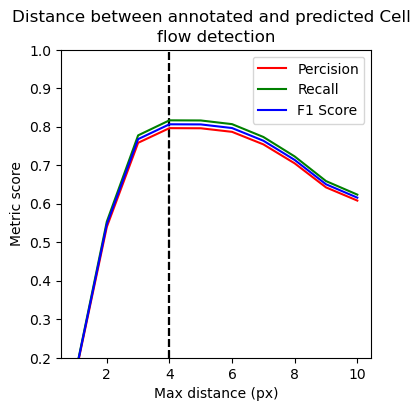

In [5]:
# get metrics on model performance and plot results
import matplotlib.pyplot as plt
%matplotlib inline

methods = ['flow']
max_dist = 10
trained = False

performance = evaluate.get_performance(blocks, methods, max_dist, trained)
evaluate.plot_performance(performance, methods)

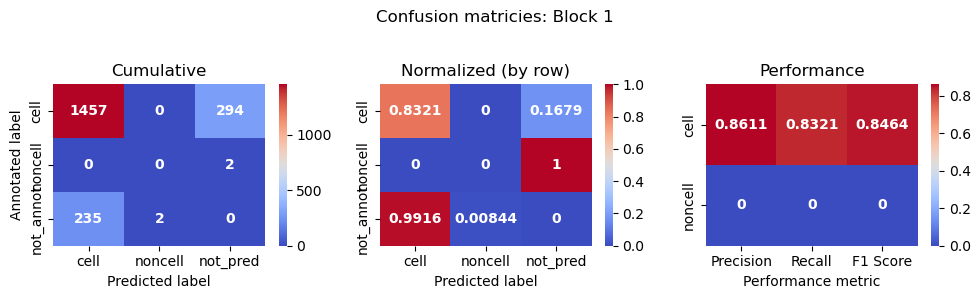

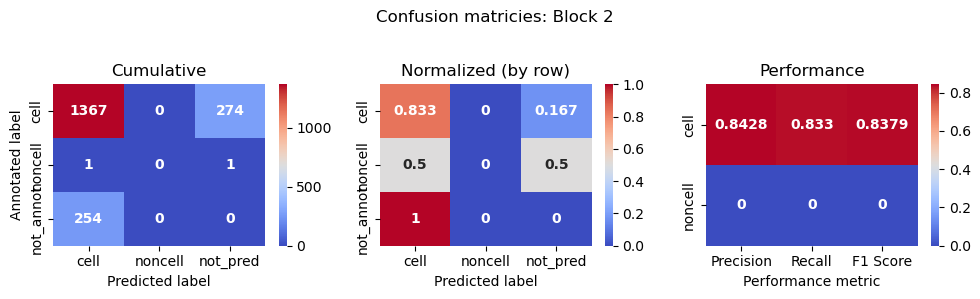

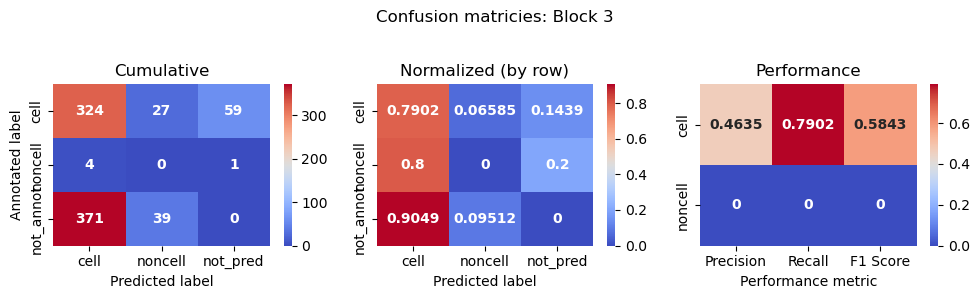

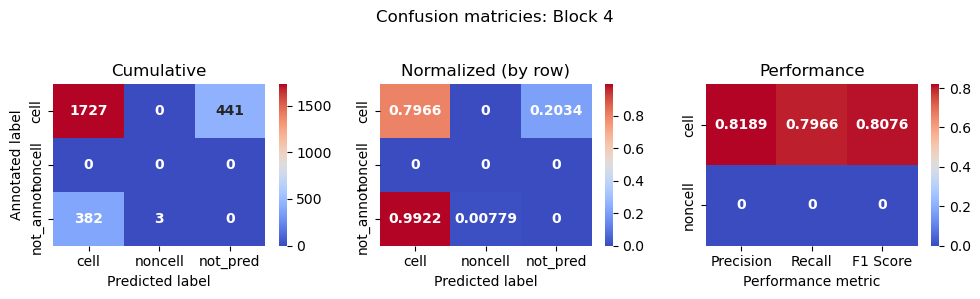

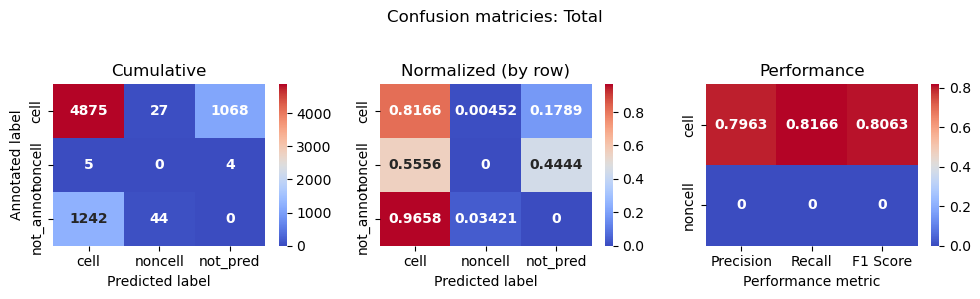

In [6]:
# Classification Matrix Plots
F1_scores = performance[2::3, :-1]
opt_vals = np.unravel_index(np.argmax(F1_scores, axis=None), F1_scores.shape)
metric_df = evaluate.annot_pred_overlap(blocks, opt_vals[0] + 1, methods[opt_vals[1]])

evaluate.plot_cm(metric_df)

### Plot Example Images

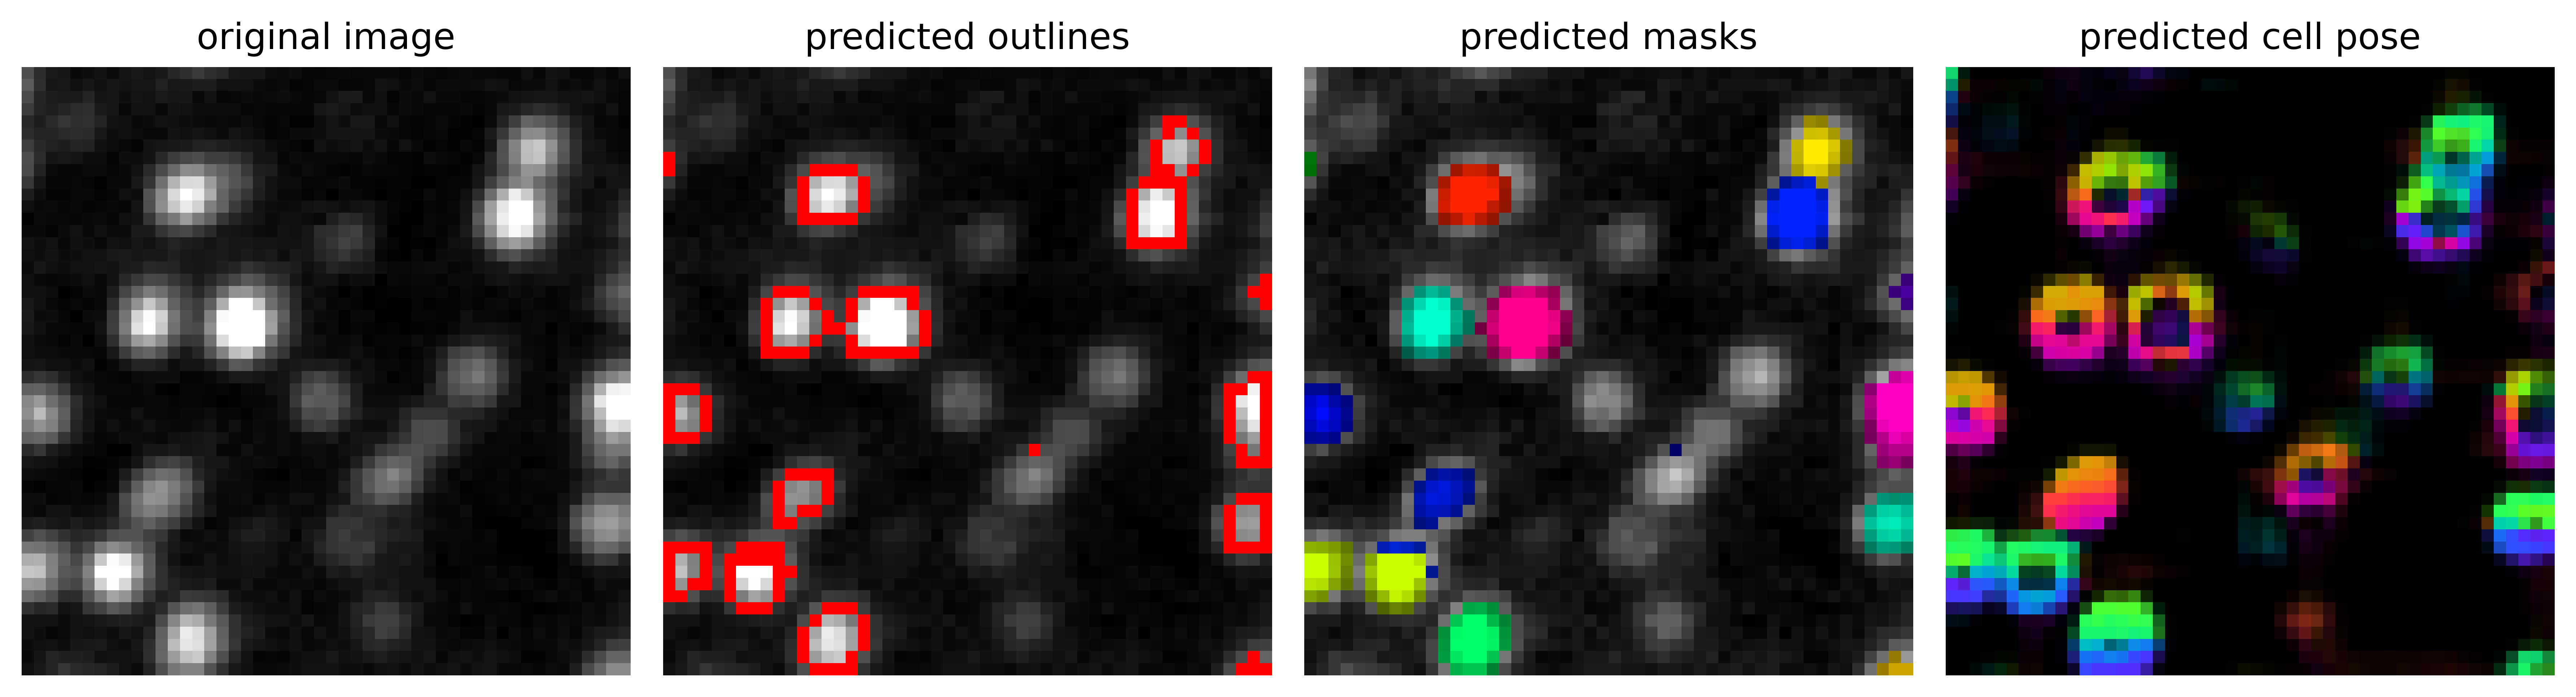

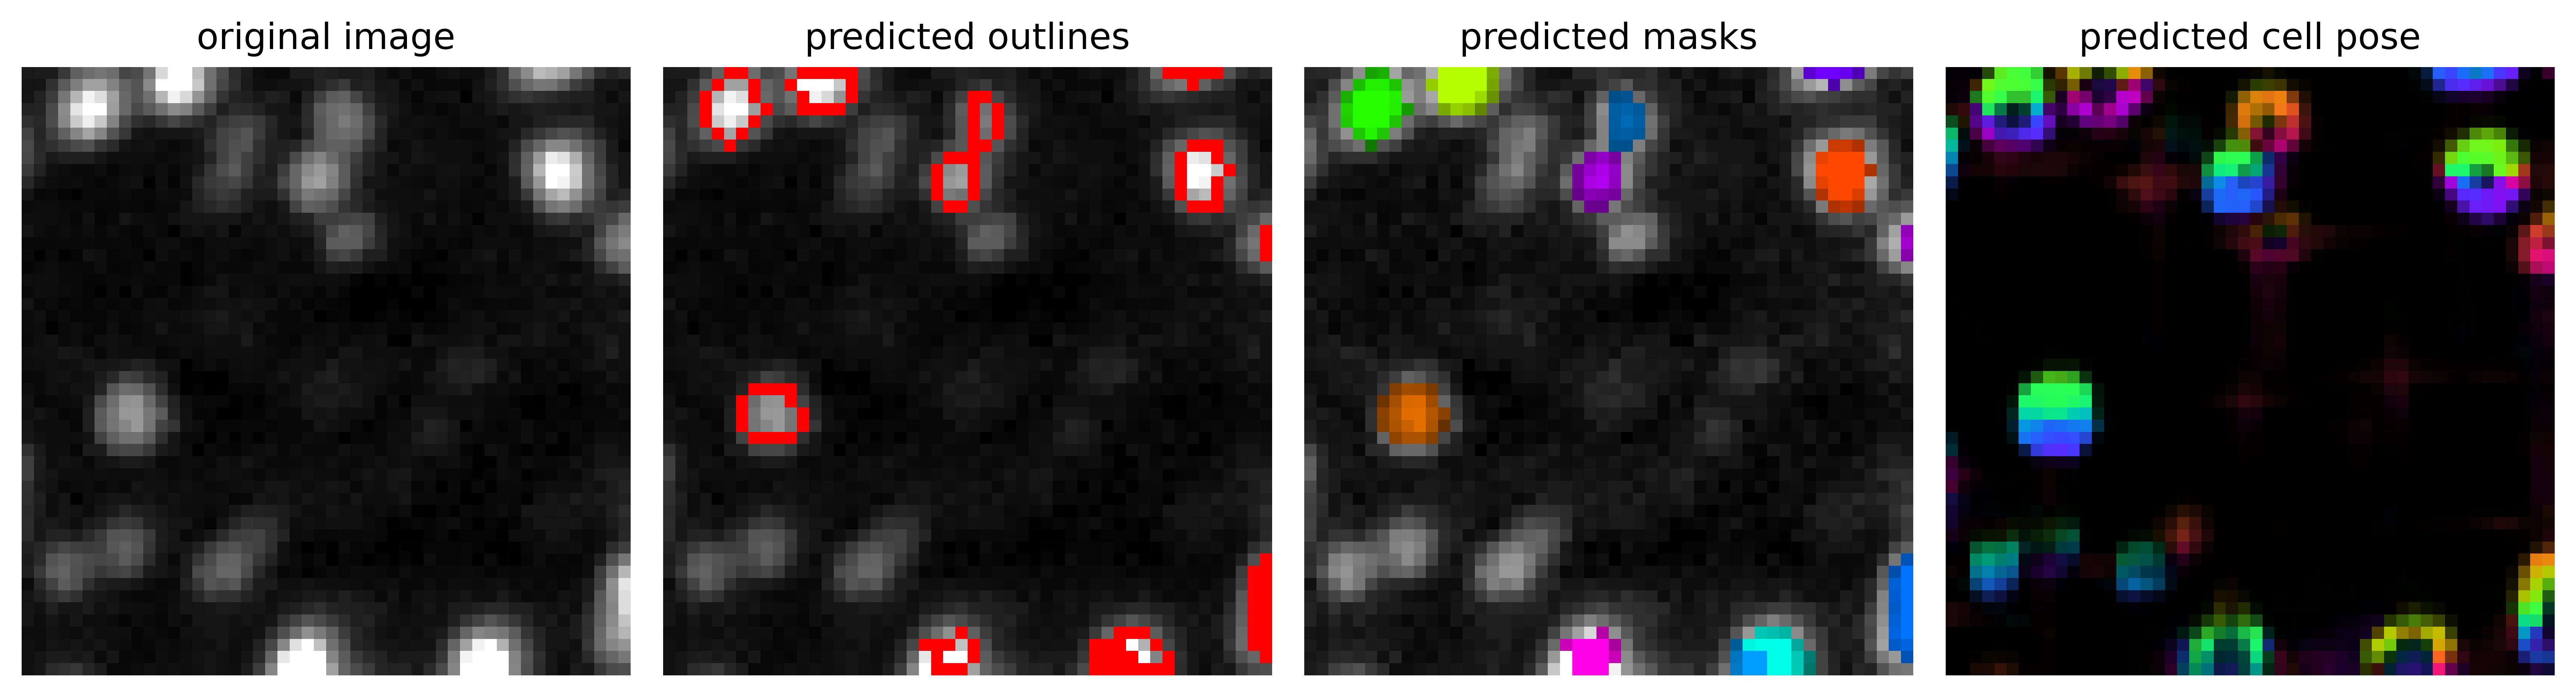

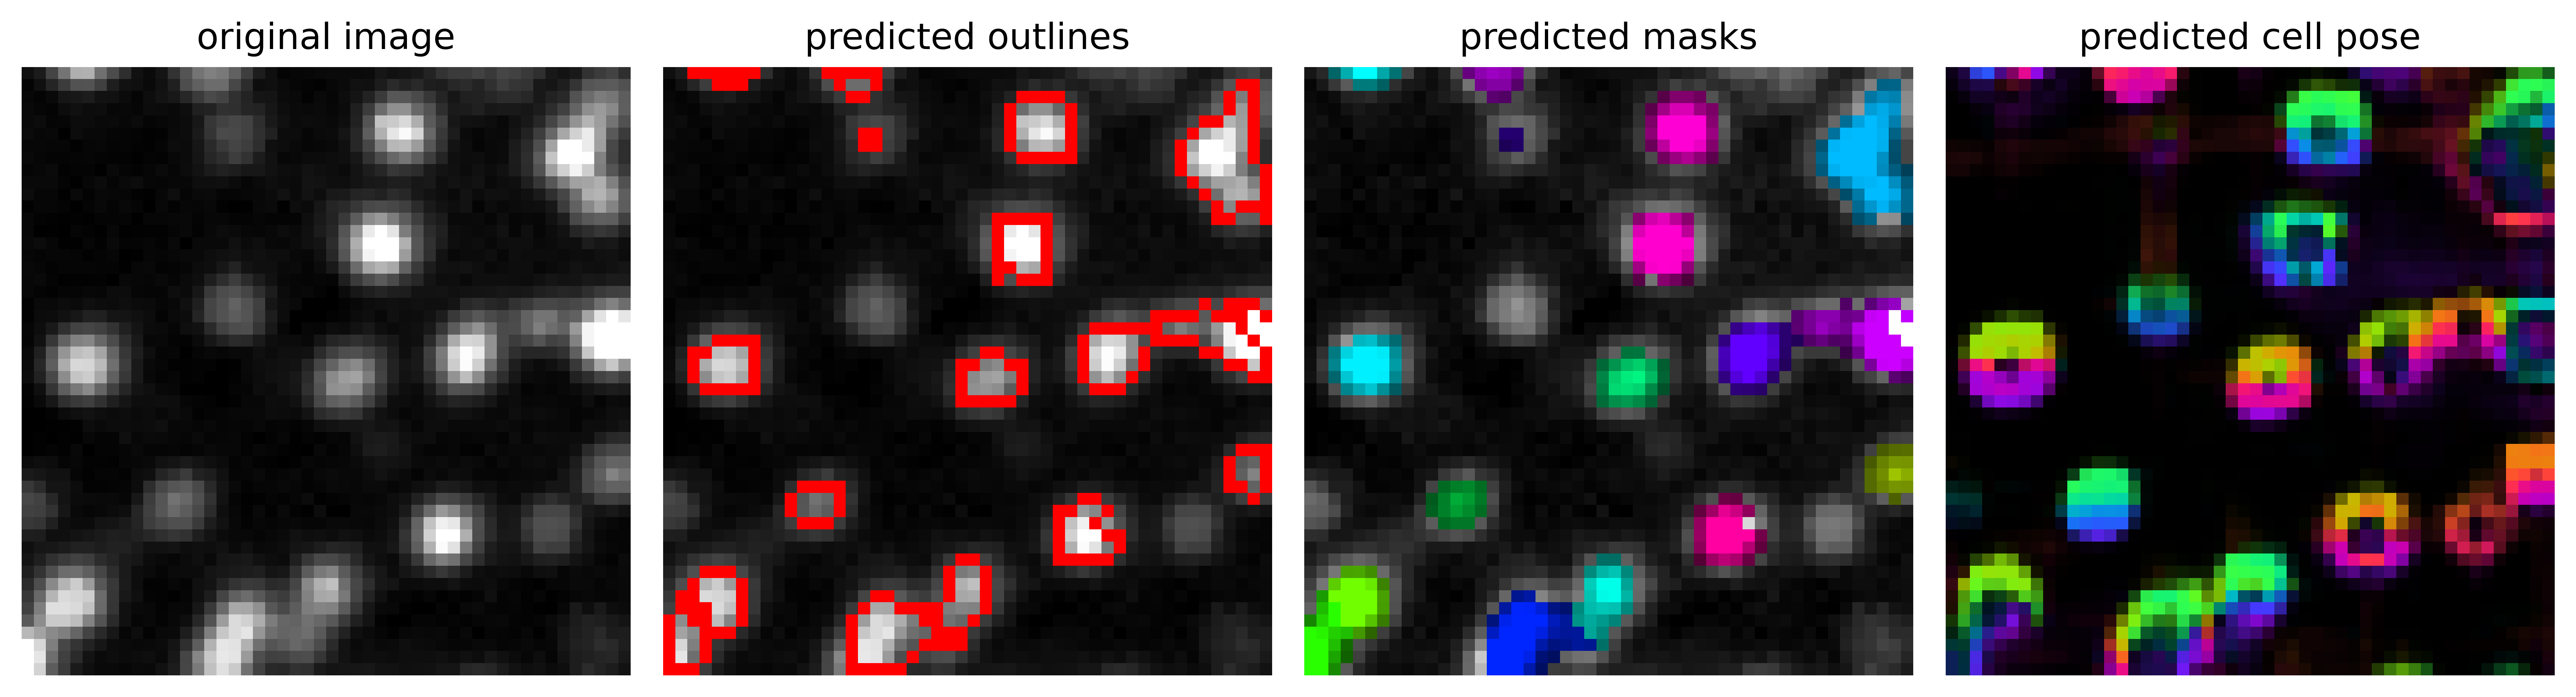

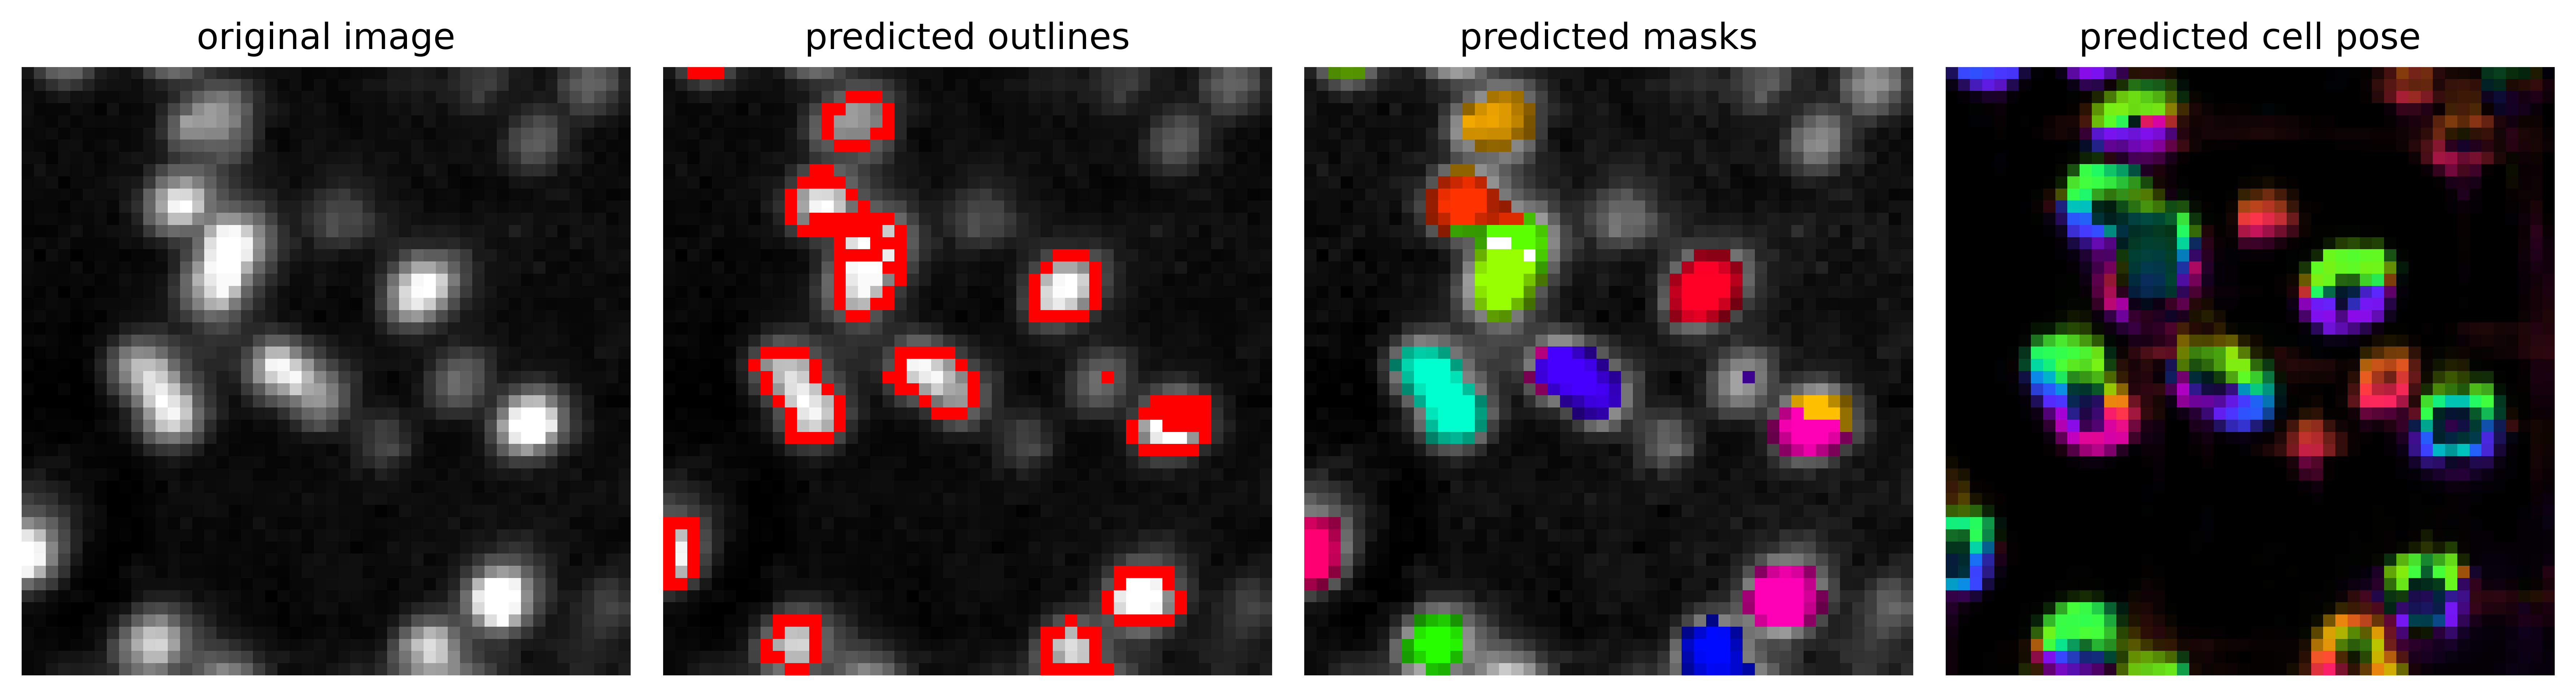

In [7]:
# plot output from 3D flows => masks
from cellpose import plot, utils
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 600

seg_path = os.path.join(output_root, 'flow','block_4_signal_seg.npy') 
seg_data = np.load(seg_path, allow_pickle=True).item()

img = seg_data['img']
masks = seg_data['masks']
flows = seg_data['flows']

crop = [100, 150]

#plot cells with masks
for idx in range(60,91,10):
    maski = masks[idx, crop[0]:crop[1], crop[0]:crop[1]]
    flowi = flows[0][idx, crop[0]:crop[1], crop[0]:crop[1]]

    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, img[idx, crop[0]:crop[1], crop[0]:crop[1]], maski, flowi)
    plt.tight_layout()
    plt.show()
    
    fig.savefig('/home/elyse/Documents/' + str(idx) + '_fig.svg', dpi = 600)
    